In [1]:
import os
import math
import yaml
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
# from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from pprint import pprint

print("Number of available GPUs: ", len(tf.config.list_physical_devices('GPU')))

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

2025-10-15 10:12:44.069354: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 10:12:44.121132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 10:12:45.835570: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Number of available GPUs:  2


I0000 00:00:1760541167.358310  395713 gpu_device.cc:2411] Ignoring visible gpu device (device: 2, name: NVIDIA T400 4GB, pci bus id: 0000:e3:00.0, compute capability: 7.5) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.


The entire processed dataset is contained within `dataset.npz`, so load it.

In [2]:
data_dir = config['data_dir']

with np.load(os.path.join(data_dir, 'dataset.npz')) as data:
    hsc_lenses = data['hsc_lens']
    hsc_nonlenses = data['hsc_nonlens']
    slsim_lenses = data['slsim_lens']
    slsim_nonlenses = data['slsim_nonlens']

print(f'hsc_lens: {hsc_lenses.shape}')
print(f'hsc_nonlens: {hsc_nonlenses.shape}')
print(f'slsim_lens: {slsim_lenses.shape}')
print(f'slsim_nonlens: {slsim_nonlenses.shape}')

hsc_lens: (50000, 41, 41, 5)
hsc_nonlens: (50000, 41, 41, 5)
slsim_lens: (50000, 41, 41, 5)
slsim_nonlens: (50000, 41, 41, 5)


Take a quick look at the four parts of the dataset: 
1. HSC Lenses
2. HSC Nonlenses
3. SLSim Lenses
4. SLSim Nonlenses

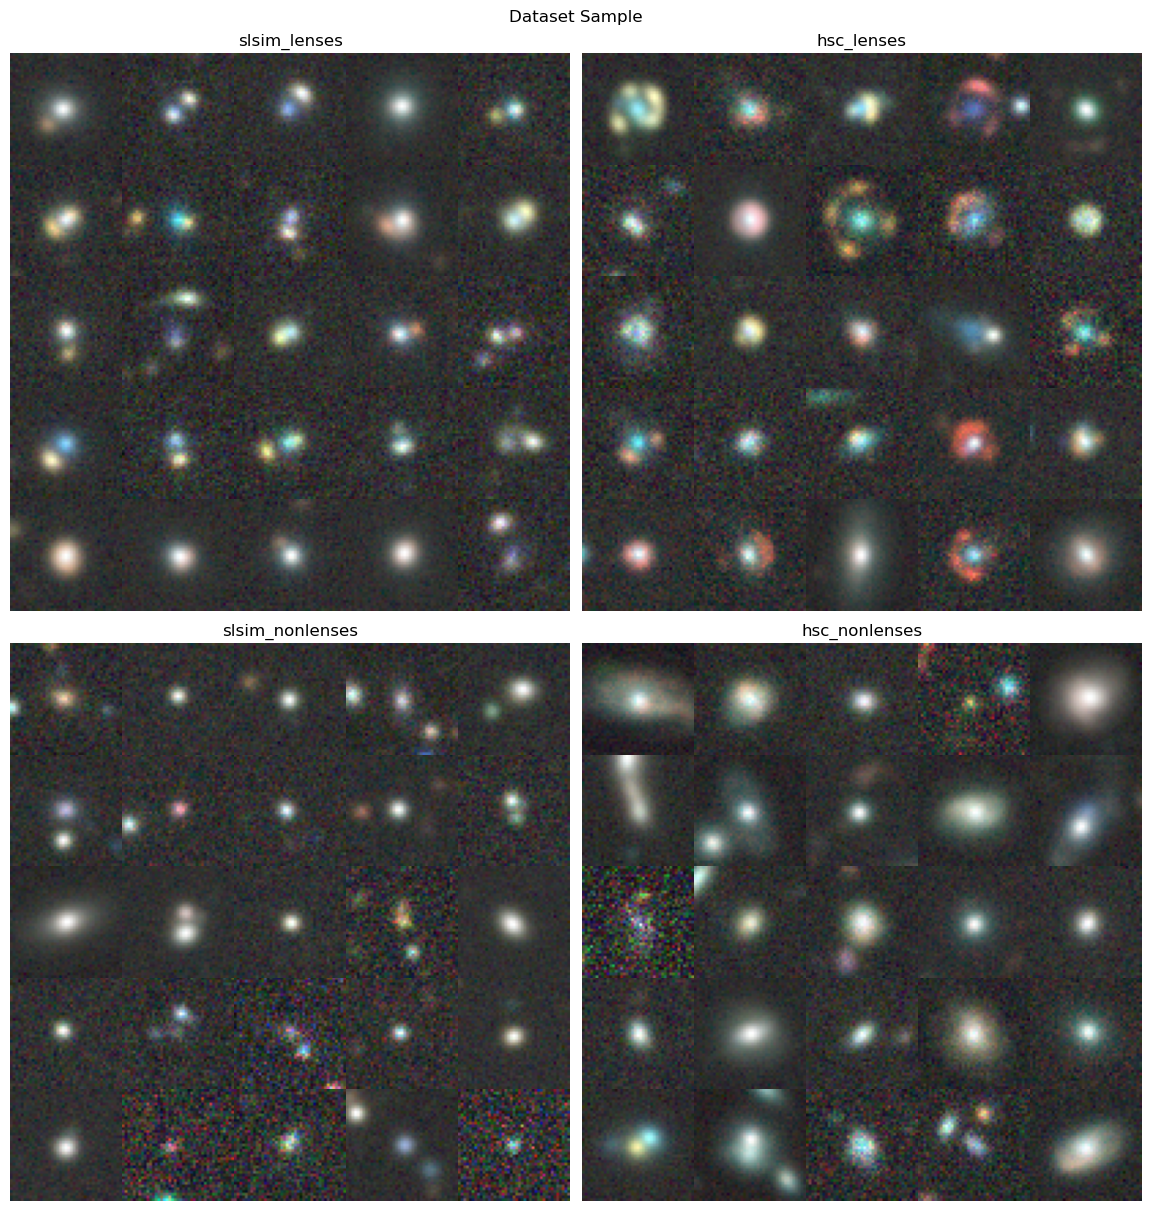

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(11.4, 12), constrained_layout=True)

datasets = [
    (slsim_lenses, "slsim_lenses"),
    (hsc_lenses, "hsc_lenses"),
    (slsim_nonlenses, "slsim_nonlenses"),
    (hsc_nonlenses, "hsc_nonlenses"),
]

for ax, (images, title) in zip(axes.flat, datasets):
    grid_size = min(25, len(images))
    grid_rows = grid_cols = int(np.ceil(np.sqrt(grid_size)))
    for i in range(grid_size):
        row = i // grid_cols
        col = i % grid_cols
        sub_ax = ax.inset_axes([col/grid_cols, 1-row/grid_rows-1/grid_rows, 1/grid_cols, 1/grid_rows])
        sub_ax.imshow(images[i][:,:,:3])
        sub_ax.axis("off")  # Hide axes for each image
    ax.set_title(title)
    ax.axis("off")  # Hide main axes

plt.suptitle('Dataset Sample')
plt.show()

Organize these four pieces into `data` and `labels` so that we can import it in a way that Tensorflow likes

In [4]:
data = np.concatenate([hsc_lenses, slsim_lenses, hsc_nonlenses, slsim_nonlenses], axis=0)
labels = np.array(([1] * (len(hsc_lenses) + len(slsim_lenses))) + ([0] * (len(hsc_nonlenses) + len(slsim_nonlenses))), dtype=np.uint8)
print(data.shape)
print(labels.shape)

(200000, 41, 41, 5)
(200000,)


Import the data and labels to a Tensorflow `Dataset`

In [5]:
ds = tf_data.Dataset.from_tensor_slices((data, labels))
ds = ds.shuffle(buffer_size=len(labels), reshuffle_each_iteration=True)

I0000 00:00:1760541242.403335  395713 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46551 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:31:00.0, compute capability: 8.9
I0000 00:00:1760541242.404632  395713 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46551 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:b1:00.0, compute capability: 8.9


Split the whole dataset into a training, validation, and test set. The training and validation sets are used in the training process, and the test set is used to evaluate the model's performance against data it hasn't been trained on.

In [6]:
# Calculate split sizes
total_size = len(labels)
train_size = int(0.95 * total_size)
val_size = total_size - train_size
print(f'end={total_size}, train={train_size}, val={val_size}')

# Split the dataset
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)

print(f"Train size: {train_ds.cardinality()}, Val size: {val_ds.cardinality()}")

end=200000, train=190000, val=10000
Train size: 190000, Val size: 10000


"Data augmentation" is a way of increasing the size of our training set, which makes the neural net perform better. Here, we're randomly flipping and rotating the images.

In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

In [8]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.batch(256).prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.batch(256).prefetch(tf_data.AUTOTUNE)

Build the model

In [9]:
# def make_model(input_shape, num_classes):
#     inputs = layers.Input(shape=input_shape)

#     # Entry block
#     x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.GlobalAveragePooling2D()(x)

#     x = layers.Dropout(0.5)(x)
#     if num_classes == 2:
#         units = 1
#     else:
#         units = num_classes

#     outputs = layers.Dense(units, activation=None)(x)
    
#     return models.Model(inputs, outputs)

In [10]:
def make_model(input_shape, num_classes, l2=1e-4):
    inputs = keras.Input(shape=input_shape)
    reg = keras.regularizers.l2(l2)

    def conv_bn_act(x, filters, kernel_size=3, strides=1):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same",
                          kernel_regularizer=reg, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        return layers.Activation("relu")(x)

    def bottleneck_block(x, filters, strides=1):
        # Bottleneck: 1x1 reduce -> 3x3 -> 1x1 expand
        shortcut = x
        reduced = max(1, filters // 4)

        x = layers.Conv2D(reduced, 1, strides=strides, padding="same",
                          kernel_regularizer=reg, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(reduced, 3, strides=1, padding="same",
                          kernel_regularizer=reg, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(filters, 1, strides=1, padding="same",
                          kernel_regularizer=reg, use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        # projection if shape/stride differs
        if strides != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, strides=strides, padding="same",
                                     kernel_regularizer=reg, use_bias=False)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        return layers.Activation("relu")(x)

    # Stem (kept gentle because input is small)
    x = layers.Conv2D(64, 3, strides=1, padding="same", kernel_regularizer=reg, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2, strides=2, padding="same")(x)

    # Residual stages (filters, blocks, first_block_stride)
    stages = [
        (128, 2, 1),
        (256, 2, 2),
        (512, 2, 2),
    ]
    for filters, blocks, first_stride in stages:
        x = bottleneck_block(x, filters, strides=first_stride)
        for _ in range(blocks - 1):
            x = bottleneck_block(x, filters, strides=1)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    units = 1 if num_classes == 2 else num_classes
    outputs = layers.Dense(units, activation=None, kernel_regularizer=reg)(x)

    return keras.Model(inputs, outputs, name="resnet_like_v1")

In [11]:
# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)
#     num_bands = input_shape[2]

#     # Entry block
#     x = layers.Conv2D(128, num_bands, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [256, 512, 728]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(num_bands, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, num_bands, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         units = 1
#     else:
#         units = num_classes

#     x = layers.Dropout(0.25)(x)
#     # We specify activation=None so as to return logits
#     outputs = layers.Dense(units, activation=None)(x)
#     return keras.Model(inputs, outputs)


# # model = make_model(input_shape=(41, 41, 5), num_classes=2)
# # keras.utils.plot_model(model, show_shapes=True)

Train the model

In [ ]:
epochs = 500

# ---- LR schedule (epoch-based warmup + cosine) ----
lr_max = 1e-4     # your current LR
lr_min = 1e-6     # floor
warmup_epochs = 5 # tweak 3–10 if needed

def warmup_cosine(epoch, lr):
    if epoch < warmup_epochs:
        # linear warmup from 0 -> lr_max
        return lr_max * (epoch + 1) / float(warmup_epochs)
    # cosine decay from lr_max -> lr_min over remaining epochs
    progress = (epoch - warmup_epochs) / float(max(1, epochs - warmup_epochs))
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * min(1.0, progress)))

lr_scheduler = keras.callbacks.LearningRateScheduler(warmup_cosine, verbose=0)

# training
model = make_model(input_shape=(41, 41, 5), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_max),  # peak LR; callback will override per-epoch
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1,
)

callbacks = [
    # early_stopping, 
    lr_scheduler
    ]

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
)

Epoch 1/500


2025-10-15 10:14:22.275159: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f1304016e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-15 10:14:22.275177: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-10-15 10:14:22.275180: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-10-15 10:14:22.477035: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-15 10:14:23.582674: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


  8/743 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - acc: 0.5003 - loss: 1.1432  

I0000 00:00:1760541269.896293  395948 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


743/743 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - acc: 0.7204 - loss: 0.7618 - val_acc: 0.8576 - val_loss: 0.5679 - learning_rate: 2.0000e-05
Epoch 2/500
743/743 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - acc: 0.9059 - loss: 0.4638 - val_acc: 0.8973 - val_loss: 0.4880 - learning_rate: 4.0000e-05
Epoch 3/500
743/743 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - acc: 0.9293 - loss: 0.4066 - val_acc: 0.9305 - val_loss: 0.4135 - learning_rate: 6.0000e-05
Epoch 4/500
743/743 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - acc: 0.9422 - loss: 0.3693 - val_acc: 0.9224 - val_loss: 0.4039 - learning_rate: 8.0000e-05
Epoch 5/500
743/743 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - acc: 0.9501 - loss: 0.3434 - val_acc: 0.9461 - val_loss: 0.3519 - learning_rate: 1.0000e-04
Epoch 6/500
743/743 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - acc: 0.9564 - loss: 0.3185 - val_acc: 0.9211 - val_loss: 0.3606 - learning_rate: 1.0000e-04
Epoch 7/500
743/743 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - acc: 0.9609 - loss: 0.3001 - val_acc: 0.9120 - val_loss: 0.40

Plot the training and validation accuracy to sanity check that the training is going as expected. We can identify overfitting and underfitting by looking at this figure:
- Ideal Scenario: Training accuracy steadily increases and levels off at a high value. Validation accuracy follows closely and also levels off at a high value.
- Overfitting Scenario: Training accuracy keeps increasing and may reach 100%, but validation accuracy peaks early and then decreases.
- Underfitting Scenario: Both training and validation accuracy remain low.

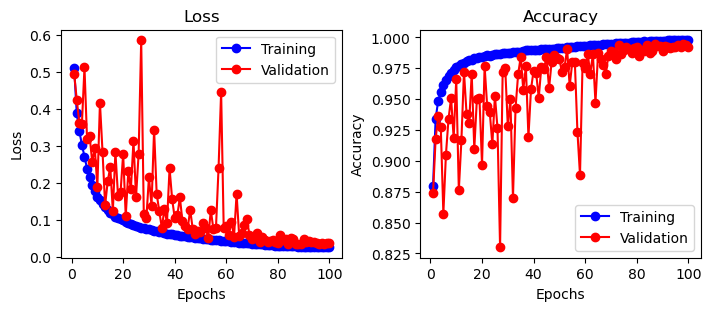

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

_, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
epoch_list = range(1, len(loss) + 1)

ax[0].plot(epoch_list, loss, 'bo-', label='Training')
ax[0].plot(epoch_list, val_loss, 'ro-', label='Validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim(0, 1)
ax[0].legend()

ax[1].plot(epoch_list, accuracy, 'bo-', label='Training')
ax[1].plot(epoch_list, val_accuracy, 'ro-', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
# ax[1].set_ylim(0, 1)
ax[1].legend()

plt.show()

In [ ]:
model.save(f'/data/bwedig/lsst-strong-lens-data-challenge/models/v5.keras')